# Model 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

In [2]:
model_df = pd.read_csv("status.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history_No Info,smoking_history_current,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0.0,0.0,1.0,1.000000,-0.645658,0.127273,-0.454545
1,0,0,0,0,0,1.0,0.0,0.0,0.349349,-0.595938,0.127273,-1.000000
2,0,0,0,0,1,0.0,0.0,1.0,-0.301301,-0.595938,-0.200000,-0.290909
3,0,0,0,0,0,0.0,1.0,0.0,-0.101101,-0.686275,-0.454545,-0.318182
4,1,1,0,0,1,0.0,1.0,0.0,0.899900,-0.763539,-0.527273,-0.318182


In [3]:
# Define features (X) and target (y)
X = model_df.drop(["diabetes"],axis=1)
y = model_df[["diabetes"]]

In [4]:
# Split data into training and test sets
X_train_, X_test, y_train_, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

In [5]:
# Random Under-Sampling to balance the training set
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train_, y_train_)
X_train.shape, X_test.shape

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


((15300, 11), (9999, 11))

In [6]:
# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model
best_rf_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.9116339869281045


In [7]:
# Evaluate model performance on training data
y_prob_train = best_rf_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))
print("AUC Score:", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7650
           1       0.93      0.95      0.94      7650

    accuracy                           0.94     15300
   macro avg       0.94      0.94      0.94     15300
weighted avg       0.94      0.94      0.94     15300

[[7113  537]
 [ 410 7240]]
AUC Score: 0.9893140159767612


In [8]:
# Evaluate model performance on test data
y_prob_test = best_rf_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print("AUC Score:", roc_auc_score(y_test, y_prob_test))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9149
           1       0.46      0.92      0.61       850

    accuracy                           0.90      9999
   macro avg       0.73      0.91      0.78      9999
weighted avg       0.95      0.90      0.92      9999

[[8246  903]
 [  72  778]]
AUC Score: 0.9785021828165084


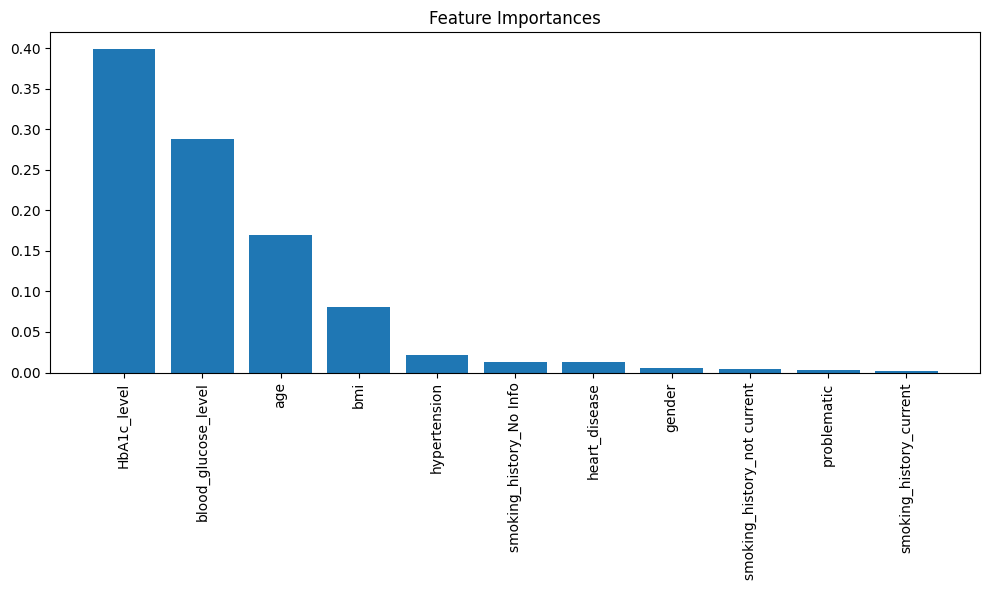

In [9]:
# Extract feature names 
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Get feature importance scores from Random Forest model
importances = best_rf_model.feature_importances_

# Sort features by importance 
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

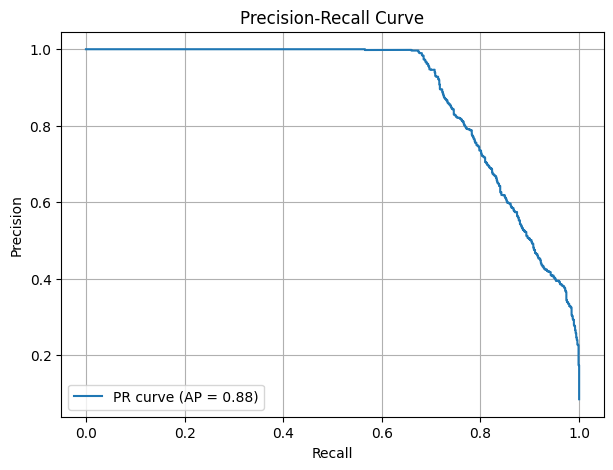

In [10]:
#Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)

ap = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [11]:
valid_idx = np.where(recall > 0.85)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_prob_test >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.6385070220504813

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9149
           1       0.61      0.85      0.71       850

    accuracy                           0.94      9999
   macro avg       0.80      0.90      0.84      9999
weighted avg       0.95      0.94      0.95      9999

Confusion Matrix (Optimized Threshold):
 [[8692  457]
 [ 127  723]]


In [12]:
valid_idx = np.where(recall > 0.90)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_prob_test >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.5384900376820924

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      9149
           1       0.50      0.90      0.64       850

    accuracy                           0.92      9999
   macro avg       0.75      0.91      0.80      9999
weighted avg       0.95      0.92      0.93      9999

Confusion Matrix (Optimized Threshold):
 [[8388  761]
 [  84  766]]
